## Chapter 3 -  Classification

### Classification Overview

Classification problems arise when the response variable / prediction is qualitative. In the loans problem, default/no default is qualitative. These are also considered to be categorical variables. 

Predicting a response for an observation is known as classifying that observation. Sometimes, a model first predicts the probability of the observation being in the class. In this sense they do behave like regression methods.

Linear regression usually are not favoured for classification problems because the classes are not considered to be ordinal. There is no natural ordering of classes most of the time. For example, if a diagnosis is to predict the classes: `seizure`, `stroke` and `overdose`, there is no natural reason to argue that one diagnosis is more mild / severe / pronounced than the others.

In the following example, we use the MNIST dataset to predict the number that is written, based on the handwriting of the image.

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     cross_val_predict)
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             precision_score, recall_score, f1_score,
                             classification_report,                              
                             precision_recall_curve, roc_curve, roc_auc_score)

def load(fname):
    mnist = None
    try:
        with open(fname, 'rb') as f:
            mnist = pickle.load(f)
            return mnist
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        with open(fname, 'wb') as f:
            mnist = pickle.dump(mnist, f)
        return mnist

### Training a Binary Classifier

Consider a classifier to predict if an image has the numeric value "5" or not. Call it a "5-detector". 

In [2]:
# Ingest
mnist_data = load('mnist.data.pkl')
X, y = mnist_data['data'], mnist_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Labelling
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [3]:
# # For testing. Note that 28*28 = 784
# print(X.shape)
# print(y.shape)

In [4]:
# # For testing. Plot the image
# sample_idk = 4
# d_single_sample = X[sample_idk]
# print(d_single_sample)
# d_single_sample_img = d_single_sample.reshape(28, 28)
# print(d_single_sample)
# plt.imshow(d_single_sample_img, cmap=matplotlib.cm.binary, interpolation='nearest')
# plt.axis('off')
# plt.show()
# print(y[sample_idk])

In [5]:
# Settings
kfold = 3

In [6]:
# Train binary classifier
sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

After training, we perform the prediction on the test set and can compare it with the original labels.

In [7]:
# Predict for the 5-dectector
print(y_test_5[50:60])
print(sgd_clf.predict(X_test[50:60]))

[False False False  True  True False  True False False False]
[False False False  True False False  True False False False]


### Performance Measures
<b> Accuracy</b> - Consider the accuracy of the SGD classifier.

In [8]:
y_predict_5 = sgd_clf.predict(X_test)
print(accuracy_score(y_test_5, y_predict_5))

0.9625714285714285


However, let's also look at the nature of this dataset and performace of the Dummy classifer that always predicts `False`.

In [9]:
print(pd.Series(y_test_5).value_counts()/len(y_test_5))

False    0.912
True     0.088
dtype: float64


In [10]:
class Dummy5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
dummy_clf = Dummy5Classifier()
dummy_clf.fit(X_train, y_train_5)

y_predict_5_2 = dummy_clf.predict(X_test)
print(accuracy_score(y_test_5, y_predict_5_2))

0.912


The dataset is mostly dominated by non-"5" values. This shows that it is dominated by `False` and can be considered a skewed dataset. 

Since only 8.8% of the observations are "5", a dummy classifier results in an error rate of 8.8% The `SGDClassifier` has an error rate of 3.7% which is only a bit lower than the dummy classifier's error rate. Hence, accuracy is generally not preferred as a performance measure for this behaviour of datasets.

<b>Confusion Matrix</b> - A binary classifier can make two types of errors: If it assigns a "5" result to a non-"5" prediction, we say that it predicted a false negative. Conversely, if it assigns a non-"5" result to a "5" result, it predicted a false positive. For completeness, a true positive is when it correctly assigns a "5" result and a true negative is when it correctly assigns a non-"5" result. 

A confusion matrix can help to see these values more obviously.

In [11]:
confusion_matrix(y_test_5, y_predict_5)

array([[9522,   54],
       [ 339,  585]])

<b>Sensitivity / Recall, Specificity / True Negative Rate</b>

From here, we can see the error rate amongst the `True` is about 8.4%. In medicine and biology, we use <u>sensitivity</u> and <u>specificity</u> to measure the performance of a classifier. In the loans problem, sensitivity is the percentage of defaulters identified, while specificity (true negative rate) is the percentage of non defaulters correctly identified. Sensitivity (true positive rate) is also known as recall. 

- $1-\text{specificity}$ is the false positive rate, also known as Type I error
- $1 -\text{ recall}$ is also known as type II error

In [12]:
recall_score(y_test_5, y_predict_5)

0.6331168831168831

<b>Precision, Recall, F1 Score</b>

Beyond that, other performance measures can be used.

Precision is $\frac{TP}{TP+FP}$, of all you predicted class 1, how many were predicted wrongly?

Recall is $\frac{TP}{TP+FN}$, of all samples that are class 1, how many were predicted wrongly?

F1 score is harmonic mean of Precision & Recall. $$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

A harmonic mean gives more weight to low values. Hence, the classifier will only get a high F1 score if both precision & recall are high.

In [13]:
print(precision_score(y_test_5, y_predict_5))
print(recall_score(y_test_5, y_predict_5))
print(f1_score(y_test_5, y_predict_5))

0.9154929577464789
0.6331168831168831
0.7485604606525911


Most classifiers computes a score / probability score based on a decision function. If this score is smaller than a threshold, the observation is assigned the negative class. Else it is assigned the positive class. We can see that as the recall improves (less false negatives), the precision will fall (more false positives)

One way to observe this is the plot the precision and recall across all the thresholds and see how the values interact.

In [14]:
# Get precisions and recalls on different thresholds
y_scores = sgd_clf.decision_function(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
prt_df = pd.DataFrame({'precision' : precisions[:-1], 'recall' : recalls[:-1], 'threshold' : thresholds})

(0.0, 1.0)

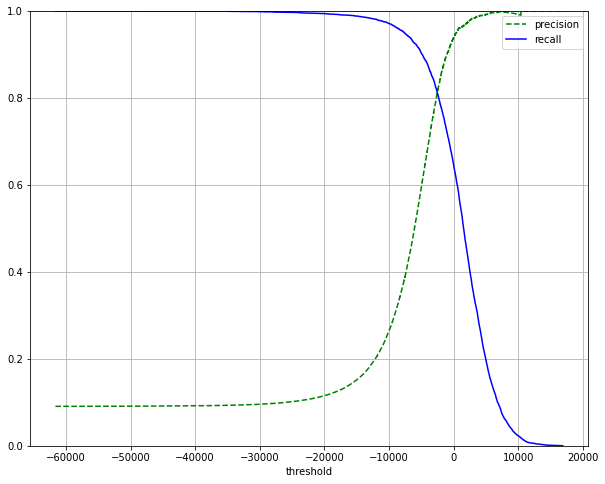

In [15]:
# Plot precision & recall against threshold
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
prt_df.plot(x='threshold', y='precision', ax=ax, color='green', style='--')
prt_df.plot(x='threshold', y='recall', ax=ax, color='blue', style='-')
ax.grid()
ax.set_ylim(0,1.0)

Alternatively, directly plot precision against recall to select the best threshold.

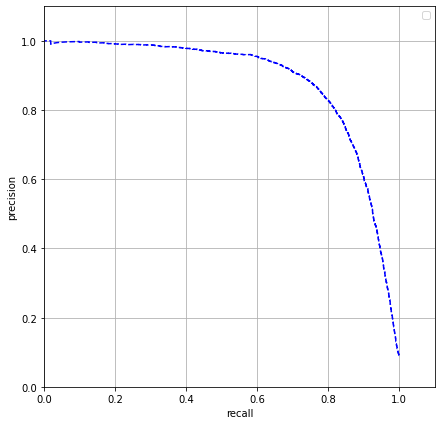

In [16]:
# Plot precision-recall curve
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
prt_df.plot(x='recall', y='precision', ax=ax, color='blue', style='--')
ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.grid()
ax.set_ylabel('precision')
ax.legend([])
plt.show()

<hr>

<b>ROC Curve, AUC-ROC</b> 

The ROC curve is popular to simultaneously display the two types of errors for all possible thresholds. The name ROC comes from communications theory, standing for Receiver Operating Characteristics. The dotted line represents the "random" classifier.

In [17]:
# Obtain the probability scores of the SGD Classifier
y_scores_5 = sgd_clf.decision_function(X_test)

# Obtain ROC values
fpr, tpr, thresholds = roc_curve(y_test_5, y_scores_5)
roc_df = pd.DataFrame({'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds})

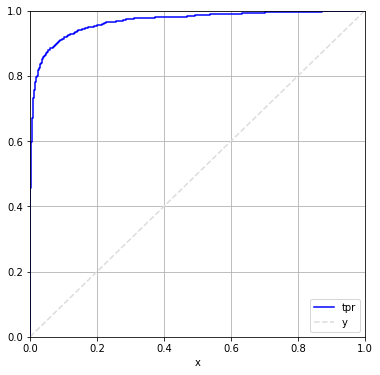

In [18]:
# Plot precision-recall curve
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
roc_df.plot(x='fpr', y='tpr', ax=ax, color='blue', style='-')
pd.DataFrame({'x' : [0.0, 1.0], 'y' : [0.0, 1.0]}).plot(x='x', y='y', style='--', color='GAINSBORO', ax=ax)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.grid()
plt.show()

In [ ]:
# Comparing with a random forest classifier
forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, y_train_5)

In [ ]:
# Obtain the probability scores of the RandomForest classifier
y_scores_52 = forest_clf.predict_proba(X_test)

# Obtain ROC values for RandomForest classifier
fpr2, tpr2, thresholds2 = roc_curve(y_test_5, y_scores_52[:,1])
roc_df2 = pd.DataFrame({'fpr' : fpr2, 'tpr' : tpr2, 'thresholds' : thresholds2})

In [ ]:
# Plot precision-recall curve
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
roc_df2.plot(x='fpr', y='tpr', ax=ax, color='red', style='-')
roc_df.plot(x='fpr', y='tpr', ax=ax, color='blue', style='--')
pd.DataFrame({'x' : [0.0, 1.0], 'y' : [0.0, 1.0]}).plot(x='x', y='y', style='--', color='GAINSBORO', ax=ax)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.grid()
ax.legend(['RandomForest', 'SGD', 'Random Guess'])
plt.show()

The overall performance of a classifier summed over all possible thresholds gives the area under the ROC curve. The larger the AUC-ROC, the better the classifier.

In [ ]:
# From here, we can conclude the RandomForest classifier has a better performance than the SGDClassifier
print(roc_auc_score(y_test_5,y_predict_5))
print(roc_auc_score(y_test_5, y_scores_52[:,1]))